<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2_Training%26Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's setup the workspace

## GitHub
Let's clone the GitHub repository containing the dataset, models, hyperparameters and utils file.

In [ ]:
!git clone https://github.com/DarioMameli/DL_Ass2
import sys
# Add the repository to the path
sys.path.insert(1, '/content/DL_Ass2/')

Cloning into 'DL_Ass2'...
remote: Enumerating objects: 1472, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1472 (delta 4), reused 21 (delta 4), pack-reused 1451
Receiving objects: 100% (1472/1472), 458.01 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (1452/1452), done.


## Packages

Let's import all the necessary functions and packages

In [ ]:
# Install the latest version of TensorFlow, which includes Keras (tf.keras)
#!pip install tensorflow --upgrade
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from keras import backend as backend
from keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from dl_utils import plot_history
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.applications as app
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from google.colab import files
import gc
import json

## Global Variables

First of all we set the seed for reproducibility of the results, and the training flags.

In [ ]:
SEED=33
HEAVY_TRAINING = False  # this is to activate the intensive process of training the 5 pretrained models with augmentation.
LIGHT_TRAINING = False  # this is to activate the less intensive process of training the tuned model WITH augmentation.
LIGHT_TRAINING_NOAUG = True # this is to activate the less intensive process of training the tuned model WITHOUT augmentation.

# Load data

Load the dataset

In [ ]:
# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/DL_Ass2/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Sort the list of files to ensure a consistent order
        #file_list = sorted(os.listdir(folder_path))

        # Iterate through sorted images in each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to a numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

Preprocess the feature vectors:


*   Resize images to fit with the pretrained networks
*   **DO NOT** normalize data values as the pretrained networks expects input values in the range [0, 255]



In [ ]:
def resize_images(images, target_size):
  # Resizing all the images
  resized_images = []
  # Resize each image to the target size using LANCZOS resampling
  for img in images:
      resized_img = img.resize(target_size, Image.LANCZOS)
      resized_images.append(resized_img)
  # Convert the list of resized images to a NumPy array
  images_array = np.array([np.array(img) for img in resized_images])

  return images_array

In [ ]:
# Define the target size
target_size = (224, 224)

# Resize images
resized_X = resize_images(X, target_size)

# Convert to numpy array
X_array = np.array([np.array(img) for img in resized_X])

# Normalization
# X_array = X_array.astype("float32")
# X_array /= 255

Show a few sample images with literal type label

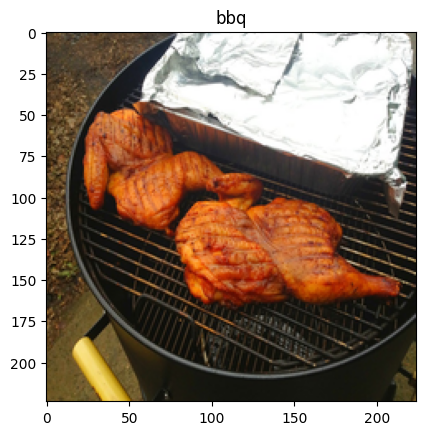

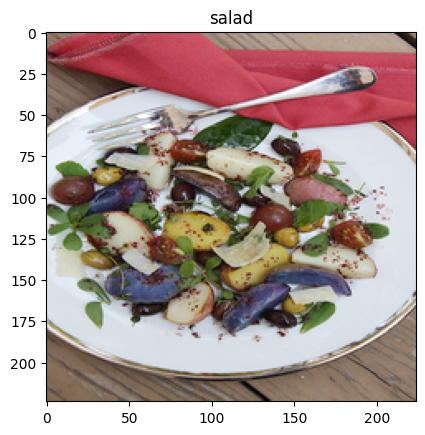

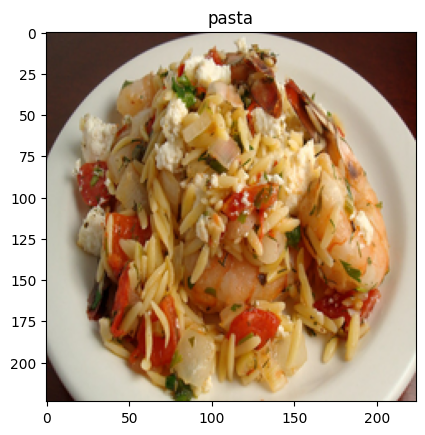

In [ ]:
plt.imshow(X_array[1000])
plt.title(y[1000])
plt.show()
plt.imshow(X_array[500])
plt.title(y[500])
plt.show()
plt.imshow(X_array[0])
plt.title(y[0])
plt.show()

Preprocess the labels (one-hot encodings)

In [ ]:
# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Transform to one hot encodings
min = np.min(y)
max = np.max(y)
print(min, max)
num_classes = max + 1
y = to_categorical(y, num_classes)

print("First label is now = ", y[0])

0 4
First label is now =  [0. 1. 0. 0. 0.]


## Testing and validation data split
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.1, shuffle=True, random_state=SEED)

# Split again training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED) # for reproducibility

print(X_train.shape[0], "train samples")
print(X_val.shape[0], "validation samples")
print(X_test.shape[0], "test samples")

1038 train samples
260 validation samples
145 test samples


# Baseline model

This model represents the baseline, and it's the best custom model seen in the labs.

In [ ]:
def CNNModel(input_shape=(32, 32, 3), num_classes=10):

    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(16, (3, 3), padding="same",  activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#Pretrained network

We are going to implement fine-tuning with optional data augmentation for our model.

In [ ]:
class MyPTCNNModel:
    def __init__(self, model_name, num_classes, data_augmentation=False, num_units=16, learning_rate=1e-4, dropout_rate=0.5):
        self.num_units = num_units
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.data_augmentation = data_augmentation
        self.num_classes = num_classes

        self.build_model(model_name)

    def build_model(self, model_name):

        # Build the base
        if model_name == 'ResNet50':
          base = app.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == 'EfficientNetB0':
          base = app.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == "DenseNet121":
          base = app.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == "EfficientNetV2B0":
          base = app.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == "MobileNet":
          base = app.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        for layer in base.layers:
            layer.trainable = False

        # Build the head
        x = base.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_units*4, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_units*2, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_units, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = BatchNormalization()(x)
        head = Dense(units=self.num_classes, activation='softmax')(x)

        # Merge base and head
        self.model = Model(inputs=base.input, outputs=head)
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           metrics=['accuracy'])

    def stop_early(self):
      # Early stop to prevent overfitting
      self.stop_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=5,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=3,
      )

    def fit(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=128, stop_early=True):
        if stop_early:
          self.stop_early()
        if self.data_augmentation:
          datagen_train = ImageDataGenerator(
              zoom_range=(0.8, 1.2),
              vertical_flip=True,
          )
          datagen_train.fit(X_train, seed=SEED)
          datagen_val = ImageDataGenerator(
              zoom_range=(0.8, 1.2),
              vertical_flip=True,
          )
          datagen_val.fit(X_val, seed=SEED)
          history = self.model.fit(
              datagen_train.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=SEED),
              validation_data=datagen_val.flow(X_val, y_val, batch_size=batch_size, shuffle=True, seed=SEED),
              epochs=epochs,
              callbacks=[self.stop_early]
              )
        else:
          history = self.model.fit(
              X_train, y_train,
              batch_size=batch_size,
              validation_data=(X_val, y_val),
              epochs=epochs,
              callbacks=[self.stop_early]
              )
        return history

    def evaluate(self, X_test, y_test):
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        return test_loss, test_acc

    def summary(self):
        return self.model.summary()

    def save(self, path):
        return self.model.save(path)

    def predict(self, x):
        return self.model.predict(x)

# Training


##Helper functions

Define a function to plot training histories for different models (as in the lab)

In [ ]:
def plot_histories(history):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  for name in history:
      ax[0][0].plot(history[name].history["loss"], label=name)
      ax[0][0].set_title("loss")
      ax[0][0].legend()
      ax[0][1].plot(history[name].history["val_loss"], label=name)
      ax[0][1].set_title("val_loss")
      ax[0][1].legend()
      ax[1][0].plot(history[name].history["accuracy"], label=name)
      ax[1][0].set_title("accuracy")
      ax[1][0].legend()
      ax[1][1].plot(history[name].history["val_accuracy"], label=name)
      ax[1][1].set_title("val_accuracy")
      ax[1][1].legend()
  plt.tight_layout()

## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

### Data preprocessing

Before training, we need to resize the data to a smaller target, in order to reduce the number of trainable parameters to accomodate for the limited resources.

In [ ]:
# Define the target size
target_size = (32, 32)

# Resize images
resized_X_32 = resize_images(X, target_size)

# Convert to numpy array
X_array_32 = np.array([np.array(img) for img in resized_X_32])

# Split the data into training and testing sets
X_train_32, X_test_32, y_train_32, _ = train_test_split(X_array_32, y, test_size=0.1, shuffle=True, random_state=SEED)

# Split again training data into training and validation
X_train_32, X_val_32, _, _ = train_test_split(X_train_32, y_train_32, test_size=0.2, shuffle=True,  random_state=SEED) # for reproducibility

print(X_train_32.shape[0], "train samples")
print(X_val_32.shape[0], "validation samples")
print(X_test_32.shape[0], "test samples")

1038 train samples
260 validation samples
145 test samples


### Training the baseline

Fit the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,389 (2.64 MB)

 Trainable params: 691,365 (2.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3579 - loss: 1.9071 - val_accuracy: 0.1846 - val_loss: 24.9061
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4290 - loss: 1.4475 - val_accuracy: 0.2308 - val_loss: 15.6705
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5469 - loss: 1.2440 - val_accuracy: 0.2308 - val_loss: 12.0127
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5265 - loss: 1.2318 - val_accuracy: 0.2231 - val_loss: 7.1013
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5105 - loss: 1.2116 - val_accuracy: 0.4000 - val_loss: 2.9796
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5684 - loss: 1.1520 - val_accuracy: 0.3192 - val_loss: 6.7469
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5486 - loss: 1.1262 - val_accuracy: 0.2308 - val_loss: 6.8123
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5875 - loss: 1.1469 - val_accuracy: 0.2385 - val_loss: 9.016

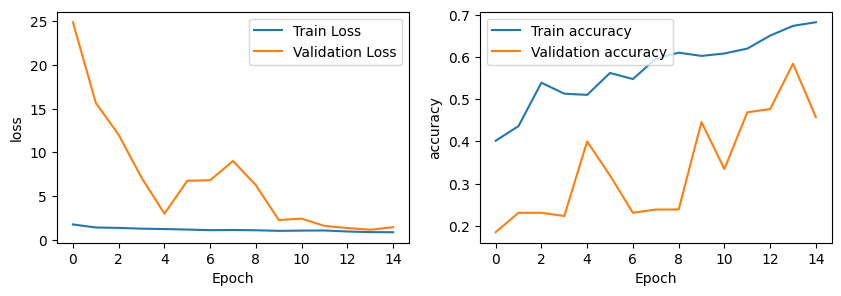

In [ ]:
batch_size = 128
epochs = 15

model = CNNModel(num_classes=num_classes)
model.summary()

history = model.fit(X_train_32, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val_32, y_val))
plot_history(history)

# Save the model
model.save('/content/DL_Ass2/models/baseline_model.keras')

## Choosing among pretrained models

We are going to fine-tune different models and choose the best performing with some standard predefined parameters.

###Training the models.

**NOTE**: the loop may not finish as the RAM could be exhausted before. We already trained the models and uploaded in the GitHub repo, therefore they are already in the workspace. Need to set **HEAVY_TRAINING** flag in the **Setup** Section to False if only evaluation is wanted.

Training 5 fine-tuned models with augmentation

In [ ]:
# STANDARD PREDEFINED PARAMETERS
NUMBER_OF_UNITS = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3
BATCH_SIZE = 128
EPOCHS = 10 # Only a few epochs should be needed to make the selection
AUGMENTATION = True
STOP_EARLY = True

models = ["ResNet50", "EfficientNetB0", "DenseNet121", "EfficientNetV2B0", "MobileNet"]

if HEAVY_TRAINING:
  histories = {}

  for name in models:
    backend.clear_session()
    print("Training:", name, "...")
    model = MyPTCNNModel(name, num_classes, data_augmentation=AUGMENTATION, num_units=NUMBER_OF_UNITS, learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE)
    #print(model.summary())
    histories[name] = model.fit(X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE, stop_early=STOP_EARLY)
    model.save('/content/' + name + '.keras')

  plot_histories(histories)

Training: DenseNet121 ...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.2466 - loss: 1.8600 - val_accuracy: 0.2769 - val_loss: 1.7011
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4370 - loss: 1.4452 - val_accuracy: 0.4269 - val_loss: 1.2570
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4671 - loss: 1.3809 - val_accuracy: 0.5731 - val_loss: 1.2305
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 779ms/step - accuracy: 0.5673 - loss: 1.1415 - val_accuracy: 0.5962 - val_loss: 1.0215
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.5699 - loss: 1.0895 - val_accuracy: 0.6462 - val_loss: 0.9326
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 848ms/step - accuracy: 0.6327 - loss: 1.0071 - val_accuracy: 0.6769 - val_loss: 0.8434
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 706ms/step - accuracy: 0.6418 - loss: 0.9533 - val_accuracy: 0.7115 - val_loss: 0.9589
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 864ms/step - accuracy: 0.6578 - loss: 0.9834 - val_accuracy: 0.7308 - val_loss: 0.8244
Epo

NameError: name 'plot_histories' is not defined

###Choose the best pretrained model

We are going to directly load the models from our GitHub repository for semplicity and to reduce cells' interdependencies, as the SEED should allow to train very similar models in the end, and reach the same conclusions.

In [ ]:
models = ["ResNet50", "EfficientNetB0", "DenseNet121", "EfficientNetV2B0", "MobileNet"]

validation_accuracies = []

for name in models:
  print("Model:", name)
  backend.clear_session()
  model = keras.models.load_model('/content/DL_Ass2/models/' + name + '.keras')
  _, acc = model.evaluate(X_val, y_val)
  validation_accuracies.append(acc)

best_model_name = models[np.argmax(validation_accuracies)]
print("The best model in terms of validation accuracy is:", best_model_name)

Model: ResNet50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 458 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 796ms/step - accuracy: 0.9254 - loss: 0.2431
Model: EfficientNetB0


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 456 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9493 - loss: 0.3306
Model: DenseNet121


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 758 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7154 - loss: 0.8321
Model: EfficientNetV2B0


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 410 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 962ms/step - accuracy: 0.4976 - loss: 1.3866
Model: MobileNet


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 196 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.6842 - loss: 1.0174
The best model in terms of validation accuracy is: EfficientNetB0


## Tune the best model

**IMPORTANT**:

Before continuing, it should be noted that the searching of the hyperparameters for our best model is performed in the notebook "DL_Assignment2_Search.ipynb", since we have seen that the process causes non negligible memory leaks that impede the following cells to execute smoothly or run at all.

Therefore, it is suggested to move to the other notebook before proceeding with the reading of this one.

In any case, the code should run regardless, as the hyperparameters have already been searched and are found in the GitHub repository.

Once again, the SEED should cause the hyperparameters found to be the same as ours.

### Train the tuned model

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.2516 - loss: 2.0316 - val_accuracy: 0.5654 - val_loss: 1.3659
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3169 - loss: 1.8168 - val_accuracy: 0.7654 - val_loss: 1.2025
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 0.4058 - loss: 1.5092 - val_accuracy: 0.8385 - val_loss: 1.0651
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 709ms/step - accuracy: 0.4784 - loss: 1.2971 - val_accuracy: 0.8846 - val_loss: 0.7435
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 712ms/step - accuracy: 0.5308 - loss: 1.2627 - val_accuracy: 0.8808 - val_loss: 0.7645
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 703ms/step - accuracy: 0.5555 - loss: 1.1270 - val_accuracy: 0.9077 - val_loss: 0.5795
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 652ms/step - accuracy: 0.6034 - loss: 0.9983 - val_accuracy: 0.9077 - val_loss: 0.5271
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 768ms/step - accuracy: 0.6597 - loss: 0.9135 - val_accuracy: 0.8962 - val_lo

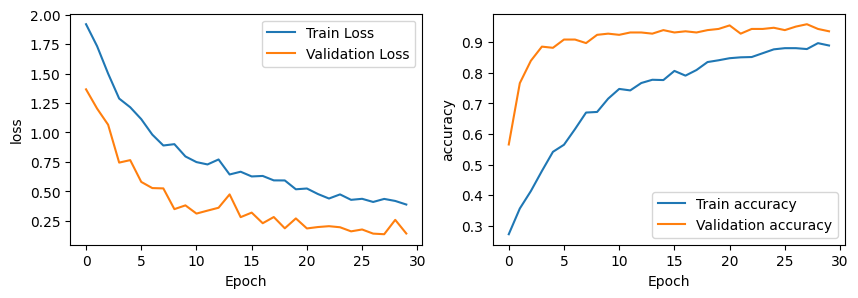

In [ ]:
# Read the JSON file and load the hyperparameters
with open("/content/DL_Ass2/best_hps.json", "r") as f:
    best_hps = json.load(f)

NUMBER_OF_UNITS = best_hps['units']
LEARNING_RATE = best_hps['learning_rate']
DROPOUT_RATE = best_hps['dropout_rate']
BATCH_SIZE = 128
EPOCHS = 30
AUGMENTATION = True
STOP_EARLY = True

if LIGHT_TRAINING:

  model = MyPTCNNModel(best_model_name, num_classes, data_augmentation=AUGMENTATION, num_units=NUMBER_OF_UNITS, learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE)

  print(f"Training {best_model_name} for {EPOCHS} epochs...")

  history = model.fit(X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE, stop_early=STOP_EARLY)

  plot_history(history)

  model.save('/content/DL_Ass2/models/' + best_model_name + '_tuned.keras')


###Train the non-augmented tuned model

In [ ]:
# Read the JSON file and load the hyperparameters
with open("/content/DL_Ass2/best_hps.json", "r") as f:
    best_hps = json.load(f)

NUMBER_OF_UNITS = best_hps['units']
LEARNING_RATE = best_hps['learning_rate']
DROPOUT_RATE = best_hps['dropout_rate']
BATCH_SIZE = 128
EPOCHS = 30
AUGMENTATION = False
STOP_EARLY = True

if LIGHT_TRAINING_NOAUG:
  model = MyPTCNNModel(best_model_name, num_classes, data_augmentation=AUGMENTATION, num_units=NUMBER_OF_UNITS, learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE)

  print(f"Training {best_model_name} for {EPOCHS} epochs...")

  history = model.fit(X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE, stop_early=STOP_EARLY)

  plot_history(history)

  model.save('/content/DL_Ass2/models/' + best_model_name + '_tuned_noAug.keras')

#Evaluation


## Helper functions

We define a function to compute class-wise accuracies given a model and the testing data.

In [ ]:
def compute_class_accuracies(X_data, y_data, model):
  # The predicted probabilities for each class
  y_pred_probs = model.predict(X_data)

  # The corresponding predicted labels
  y_pred_labels = np.argmax(y_pred_probs, axis=1)

  # The corresponding true labels
  y_true_labels = np.argmax(y_data, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_true_labels, y_pred_labels)

  # Compute accuracies and weights for each class
  class_accuracies = []
  for class_label in range(len(cm)):
      class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
      class_accuracies.append(class_accuracy)

  # Print the classification report
  print(classification_report(y_true_labels, y_pred_labels))

  return class_accuracies


## Baseline evaluation

Print the loss and accuracy of the trained baseline model.

In [ ]:
model = keras.models.load_model('/content/DL_Ass2/models/baseline_model.keras')

base_score = model.evaluate(X_test_32, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 1.3830674886703491
Test accuracy: 0.5034482479095459


##Tuned Models evaluation

Here we compute the class accuracies and F1 for the two tuned models, with and without augmentation.

In [ ]:
# TUNED AUGMENTED -------------------------------------------------------------

name = "EfficientNetB0_tuned"

model = keras.models.load_model('/content/DL_Ass2/models/'+ name +'.keras')

# Compute class-wise accuracies of the tuned model with augmentation
class_accuracies = compute_class_accuracies(X_test, y_test, model)

# Print class labels along with their accuracies
print("Model:", name)
for class_label, accuracy in enumerate(class_accuracies):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

best_score = model.evaluate(X_test, y_test)
print(f"{name} accuracy: {best_score}")

# TUNED NOT AUGMENTED ---------------------------------------------------------

name = "EfficientNetB0_tuned_noAug"

model = keras.models.load_model('/content/DL_Ass2/models/'+ name +'.keras')

# Compute class-wise accuracies of the tuned model without augmentation
class_accuracies_noAug = compute_class_accuracies(X_test, y_test, model)

# Print class labels along with their accuracies
print("Model:", name)
for class_label, accuracy in enumerate(class_accuracies_noAug):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

best_score_noAug = model.evaluate(X_test, y_test)
print(f"{name} accuracy: {best_score_noAug}")

# -----------------------------------------------------------------------------

# Evaluate and print results for overall accuracy
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.97      0.97      0.97        34
           2       0.96      1.00      0.98        25
           3       1.00      0.94      0.97        17
           4       0.97      0.97      0.97        37

    accuracy                           0.98       145
   macro avg       0.98      0.98      0.98       145
weighted avg       0.98      0.98      0.98       145

Class 0: Accuracy 1.00
Class 1: Accuracy 0.97
Class 2: Accuracy 1.00
Class 3: Accuracy 0.94
Class 4: Accuracy 0.97


#Transformation test

In [ ]:
# Create the same ImageDataGenerator for augmentation as in the definition of our model
datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip = True,
  fill_mode='nearest',
  validation_split=0.2
)

# Lists to store augmented data
X_augmented = []
y_augmented = []

# The predicted probabilities for each class
y_pred_probs = model.predict(X_test)
# The corresponding predicted labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Iterate through all training examples
for i in range(len(X_test)):
    # Reshape the image to (1, height, width, channels) for flow method
    img = X_test[i].reshape((1,) + X_test[i].shape)

    # Generate augmented images and store in X_augmented and y_augmented
    for batch, labels_batch in datagen.flow(img, y_test[i].reshape(1, -1), batch_size=1):
        X_augmented.append(batch[0].reshape(X_test[i].shape))
        y_augmented.append(labels_batch[0])
        break  # Exit the loop after one augmented image

# Convert lists to NumPy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Check the shape of augmented data
print("Shape of X_augmented:", X_augmented.shape)
print("Shape of y_augmented:", y_augmented.shape)

# The predicted probabilities for each class
y_pred_probs_aug = model.predict(X_augmented)
# The corresponding predicted labels
y_pred_labels_aug = np.argmax(y_pred_probs_aug, axis=1)

# Display the first 10 examples
for i in range(10):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].reshape(X_test[i].shape), cmap="gray")
    plt.title(f'True: {np.argmax(y_test[i])}, Predicted: {y_pred_labels[i]}, Probability: {y_pred_probs[i, y_pred_labels[i]]:.4f}')

    plt.subplot(1, 2, 2)
    plt.imshow(X_augmented[i].reshape(X_augmented[i].shape), cmap="gray")
    plt.title(f'True: {np.argmax(y_augmented[i])}, Predicted: {y_pred_labels_aug[i]}, Probability: {y_pred_probs_aug[i, y_pred_labels_aug[i]]:.4f}')

    plt.show()


## Layer activations

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
#define the function to get the access to the layers input
def get_layer_output(model, layer_name):
    return Model(model.inputs,
                 model.get_layer(layer_name).output)

In [ ]:
#param model, trained model
#param test_instance , test set
def layer_activation(model,test_instance):
  layer_name = "conv2d"
  num_filters = dnn_model.get_layer(layer_name).output.shape[-1]
  get_activations = get_layer_output(model, layer_name)
  activations = get_activations(np.expand_dims(test_instance, axis=0))[0]
  rows_cols = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  fig.suptitle(layer_name)
  for filter_idx in range(num_filters):
      ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(activations[:, :, filter_idx])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

## Maximally activating images

In [ ]:
def get_excitement(images, model, layer_name, filter_idx, batch_size=128):
    excitements = np.array([])
    get_activations = get_layer_output(model, layer_name)
    for i in range(0, len(images), batch_size):
        activations = get_activations(images[i : i + batch_size])[:, :, :, filter_idx]
        excitements = np.hstack([excitements, np.mean(np.abs(activations), axis=(1, 2))])
    return excitements

In [ ]:
def get_top_exciting_instances(images, model,
                               layer_name, filter_idx, top=4):
    excitements = get_excitement(images, model,
                                 layer_name, filter_idx)
    excitements_idx = np.argsort(excitements)[-top:][::-1]
    return excitements_idx, excitements[excitements_idx]

In [ ]:
def show_exciting_images(images, model, layer_name, filter_idx, top=4):
    excitements_idx, excitements = get_top_exciting_instances(images, model, layer_name, filter_idx, top)
    rows_cols = int(np.ceil(np.sqrt(top)))
    fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
    for i, excitement_idx in enumerate(excitements_idx):
        ax[i // rows_cols][i % rows_cols].imshow(images[excitement_idx])
    fig.tight_layout()
    plt.show()

In [ ]:
conv_layers = [layer.name for layer in dnn_model.layers if layer.name.startswith("conv2d")]

show_exciting_images(X_train, dnn_model, conv_layers[1], filter_idx=3)

## Deconvolving an activation

In [ ]:
excitements_idx, excitements = get_top_exciting_instances(X_train, model, layer_name, filter_idx)
get_activations = get_layer_output(model, layer_name)
activations = get_activations(X_train[excitements_idx])[:, :, :, filter_idx]

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for act in range(len(activations)):
    ax[act // 2][act % 2].imshow(activations[act])
fig.tight_layout()

In [ ]:
def make_deconvolving_model(model, layer_name, filter_idx):
    conv_layers = [layer.name for layer in model.layers if layer.name.startswith("conv2d")]
    layer_idx = conv_layers.index(layer_name)
    dec_model = Sequential()
    dec_model.add(Input(model.get_layer(conv_layers[0]).output.shape[1:3] + (1,)))
    for idx in range(layer_idx, 0, -1):
        original = model.get_layer(conv_layers[idx])
        prev = model.get_layer(conv_layers[idx - 1])
        deconv = Conv2DTranspose(
            prev.filters, kernel_size=prev.kernel_size, padding="same", activation="relu", use_bias=False
        )
        dec_model.add(deconv)
    original = model.get_layer(conv_layers[0])
    final = Conv2DTranspose(3, kernel_size=original.kernel_size, padding="same", activation="relu", use_bias=False)
    dec_model.add(final)
    for idx, lyr in enumerate(dec_model.layers):
        original = model.get_layer(conv_layers[layer_idx - idx])
        orig_weights = original.get_weights()[0]
        if idx == 0:
            orig_weights = orig_weights[..., filter_idx, None]
        lyr.set_weights([orig_weights])
    return dec_model

In [ ]:
preds = deconvolving_model.predict(np.expand_dims(activations, axis=3))
preds.shape

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for act in range(len(activations)):
    ax[act // 2][act % 2].imshow(preds[act])
fig.tight_layout()

## Image occlusion

In [ ]:
def occlude_image(img, pos=(0, 0), size=6, color=(0.5, 0.5, 0.5)):
    img = img.copy()
    img[pos[0] : pos[0] + size, pos[1] : pos[1] + size, :] = color
    return img

In [ ]:
def generate_occluded_images(img, occlusion_size=6, **kwargs):
    images = []
    for y in range(0, img.shape[0] - occlusion_size + 1):
        for x in range(0, img.shape[1] - occlusion_size + 1):
            images.append(occlude_image(img, pos=(y, x), **kwargs))
    return np.array(images)

In [ ]:
occlusion_size = 8
occluded_images = generate_occluded_images(test_instance, occlusion_size=occlusion_size)

In [ ]:
original_pred = model.predict(np.array([test_instance]))[0]
original_prob = original_pred[np.argmax(original_pred)]
original_pred, np.argmax(original_pred), original_prob

In [ ]:
predictions = model.predict(occluded_images)
predictions.shape

In [ ]:
plt.plot(predictions[:, np.argmax(original_pred)])
plt.hlines(original_prob, xmin=0, xmax=len(predictions), colors="r")

In [ ]:
#create the heatmap
heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size + 1):
    for x in range(0, heatmap.shape[1] - occlusion_size + 1):
        prob = predictions[pred_idx, np.argmax(original_pred)]
        heatmap[y : y + occlusion_size, x : x + occlusion_size, :] += (max(0, original_prob - prob), 0, 0)
        pred_idx += 1

heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])

In [ ]:
assert pred_idx == len(occluded_images)

In [ ]:
plt.imshow(test_instance, alpha=0.6)
plt.imshow(heatmap, alpha=0.7)

In [ ]:
heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size + 1):
    for x in range(0, heatmap.shape[1] - occlusion_size + 1):
        probs = predictions[pred_idx, :]
        if np.argmax(probs) != np.argmax(original_pred):
            heatmap[y : y + occlusion_size, x : x + occlusion_size, :] += (1, 0, 0)
        pred_idx += 1

heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])

plt.imshow(test_instance, alpha=0.6)
plt.imshow(heatmap, alpha=0.7)

## Saliency maps

In [ ]:
original_pred = dnn_model.predict(np.array([test_instance]))[0]
original_idx = np.argmax(original_pred)
original_prob = original_pred[original_idx]
original_pred, original_idx, original_prob

In [ ]:
def prob_diff_loss(img, oimg, oidx, oprob, **k):
    return (model(img + oimg)[0, oidx] - oprob)

def l1_loss(img, l=0.1, **k):
    return ops.max(ops.abs(img)) * l

optimizer = KerasOptimizer([prob_diff_loss, l1_loss])

In [ ]:
img_optimized = np.zeros((1,) + test_instance.shape, dtype="float32")
img_optimized, loss = optimizer.optimize(img_optimized, iterations=50, learning_rate=0.1, oimg=test_instance, oidx=original_idx, oprob=original_prob)

In [ ]:
x = np.clip(img_optimized + test_instance, 0, 1)[0]
new_prob = model.predict(np.array([x]))[0][original_idx]

print("Original probability:", original_prob, "-- new probability:", new_prob)
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(test_instance)
ax[1].imshow(x)
ax[2].imshow((x - test_instance)*4)